# Prediction of the second round presidential elections of 2017.

*Gaspard Michel, Raphaël Gervillié* 

This challenge was done as part of the [Datacamp](https://github.com/x-datascience-datacamp) 2021-2022 course.

![IPP.jpg](https://www.ip-paris.fr/themes/project/img/home/logo_og.jpg)



## Introduction

France, like many countries, operates by the system of universal suffrage. During each vote, 
the results are final when all the votes have finished being counted. But some estimation can be made on the final results during the day. This challenge proposes to explore models allowing to predict the results using only half of the votes. This type of challenge is part of all the economic issues that are seeing a revival with the arrival of machine learning methods. With the increase of available data in open access, it is possible to better model complex economic problems. This challenge therefore aims on the one hand to improve the estimate of the election results and on the other hand to propose an original model allowing to capture the multiple dimensions of this problem.


## Data description

The particularity of the approach comes from the multiple sources of data that are provide for this challenge. We  have the **economic data** at the regional level and at the commune level. These data make it possible to capture the economic situation of a municipality. For example, we have information on the number of businesses, the average tax revenue or the size of the population. All of these factors provide information on voting intentions. The second source of data corresponds to data from **previous elections**. As we are planning the second round, we can use the results of the first round of the presidential elections. Finally, one of the particularity of voting in France comes from its very marked spatial character, this is why we have integrated **spatial data**. To integrate spatial information in our modeling we also provide a graph. Having as node the communes and as link the distance which separates them. We considered that a distance greater than 10km had less influence. Thus there is a link between two municipalities if their distance is less than 10 km. We will see later in this notebook that the spatial dimension plays an important role in modelling.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import networkx as nx
import pandas as pd
import numpy as np



### Economic data

The economic data comes from [INSEE](https://www.data.gouv.fr/en/datasets/data-insee-sur-les-communes/). They are of two types of scale, by communes and by region. They are used to model the economic and structural situation of municipalities.


#### Communes level.



In [33]:
node_features = pd.read_csv('data/node_features.csv',low_memory=False)


In [34]:
node_features.head()

,node_id,reg_id,dep_id,Inscrits_t2,y,Votants_t1,Abstentions_t1,Inscrits_t1,Resultat_t1,Population,...,Score Urbanité,Indice Evasion Client,Capacité Fiscale,Nb de Commerce,Nb Industries des biens intermédiaires,Valeur ajoutée régionale,Nb de Services aux particuliers,"Nb institution de Education, santé, action sociale, administration",PIB Régionnal,Moyenne Revenus Fiscaux Régionaux
0,0,0,0,887,0.587849,723.0,164.0,887.0,"{'Marine LE PEN': 184, 'Emmanuel MACRON': 155,...",816.0,...,0.0,0.0000,118.0,9350.0,9364.0,86957.458359,3372.0,15105.0,173681.0,10458.0
1,1,0,0,4358,0.647779,3296.0,1061.0,4357.0,"{'Marine LE PEN': 788, 'Emmanuel MACRON': 741,...",6456.0,...,87.5,0.0000,190.0,9350.0,9364.0,86957.458359,3372.0,15105.0,173681.0,10458.0
2,2,0,0,220,0.589744,187.0,33.0,220.0,"{'Marine LE PEN': 52, 'François FILLON': 39, '...",300.0,...,0.0,0.0000,112.0,9350.0,9364.0,86957.458359,3372.0,15105.0,173681.0,10458.0
3,20,0,1,1818,0.540260,1392.0,426.0,1818.0,"{'Marine LE PEN': 368, 'François FILLON': 297,...",2130.0,...,0.0,2111.8717,121.0,9350.0,9364.0,86957.458359,3372.0,15105.0,173681.0,10458.0
4,76,0,2,902,0.514286,702.0,200.0,902.0,"{'Marine LE PEN': 218, 'Emmanuel MACRON': 141,...",1156.0,...,0.0,0.0000,110.0,9350.0,9364.0,86957.458359,3372.0,15105.0,173681.0,10458.0


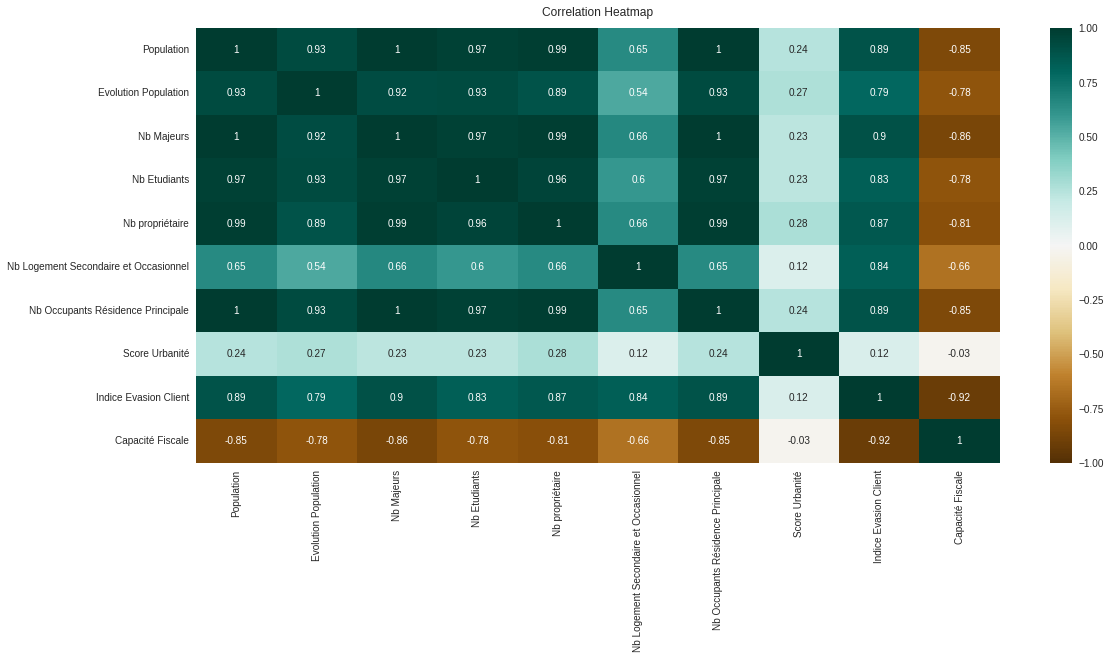

In [35]:
features_elections = ['Inscrits_t2',"Votants_t1",'Abstentions_t1', 'Inscrits_t1', 'Resultat_t1']
features_eco = ['Population','Evolution Population', 'Nb Majeurs', 'Nb Etudiants', 'Nb propriétaire',
'Nb Logement Secondaire et Occasionnel','Nb Occupants Résidence Principale', 'Score Urbanité',
'Indice Evasion Client', 'Capacité Fiscale']
plt.figure(figsize=(18, 8))
heatmap = sns.heatmap(node_features[features_eco].corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### Region level.

In [7]:
region_features=pd.read_csv("data/region.csv")

In [8]:
features_region = ['Nb de Commerce', 'Nb Industries des biens intermédiaires',
       'Valeur ajoutée régionale', 'Nb de Services aux particuliers',
       'Nb institution de Education, santé, action sociale, administration',
       'PIB Régionnal', 'Moyenne Revenus Fiscaux Régionaux']

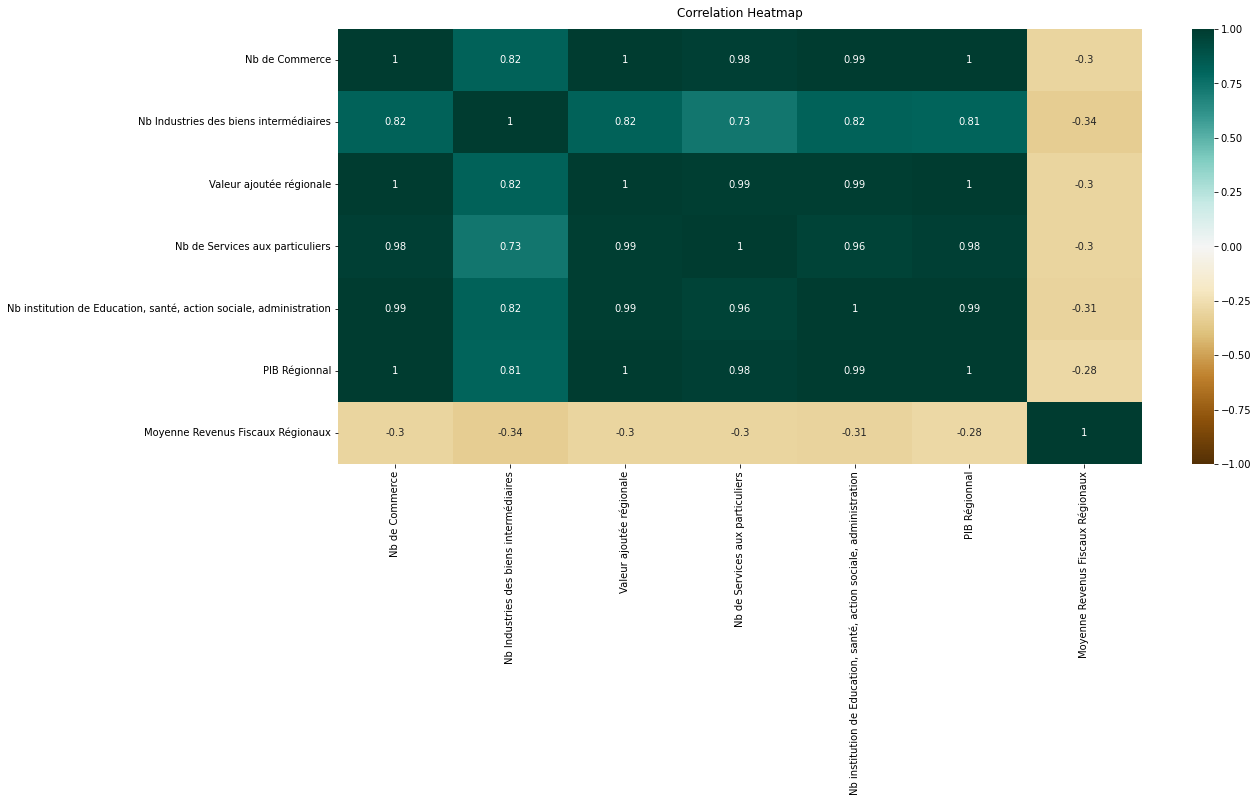

In [9]:
plt.figure(figsize=(18, 8))
heatmap = sns.heatmap(region_features[features_region].corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Elections

Data on presidential elections or more generally on votes in France are available on the [data.gouv](https://www.data.gouv.fr/fr/pages/donnees-des-elections/) platform.
As we are interested in the second round. We have provided data from the first round of the presidential elections which is a very good proxy for the second round. We have not added other votes (legislative, European, etc.), because we considered that the information was already contained in the results of the first round. The following figures present the results of the first and second round of the 2017 presidential election. Note that the results are slightly different from the official results. The reason comes from missing data of certain municipalities, in particular the DROM  (Départements ou Régions français d’Outre-Mer) and the COM (Collectivités d'Outre-Mer). 

In [10]:
node_features[features_elections].head()

,Inscrits_t2,Votants_t1,Abstentions_t1,Inscrits_t1,Resultat_t1
0,887,723.0,164.0,887.0,"{'Marine LE PEN': 184, 'Emmanuel MACRON': 155,..."
1,4358,3296.0,1061.0,4357.0,"{'Marine LE PEN': 788, 'Emmanuel MACRON': 741,..."
2,220,187.0,33.0,220.0,"{'Marine LE PEN': 52, 'François FILLON': 39, '..."
3,1818,1392.0,426.0,1818.0,"{'Marine LE PEN': 368, 'François FILLON': 297,..."
4,902,702.0,200.0,902.0,"{'Marine LE PEN': 218, 'Emmanuel MACRON': 141,..."


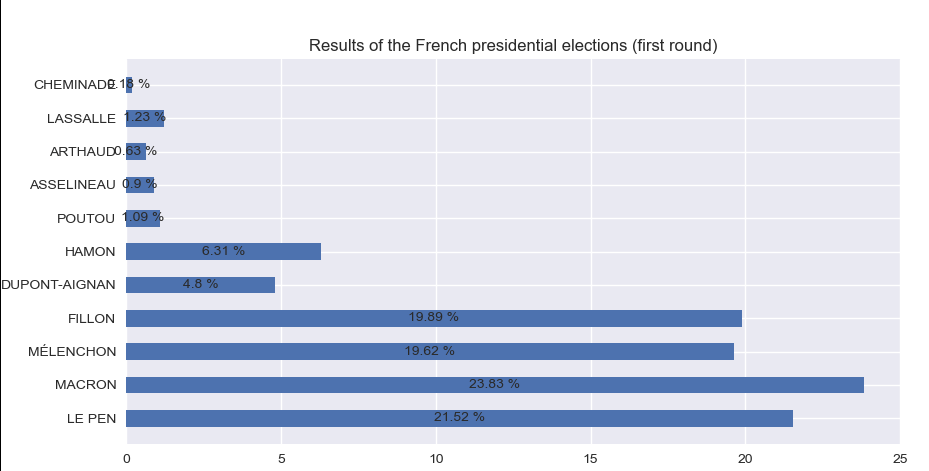

In [4]:
display.Image("images/restults_t1_screen.png")

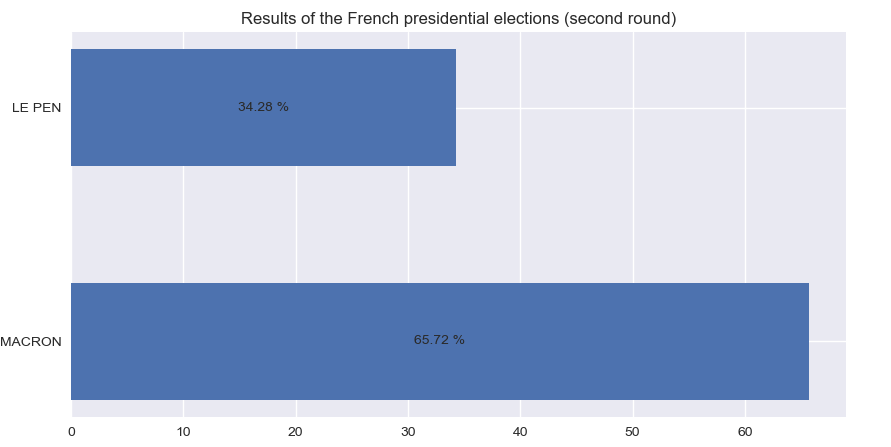

In [7]:
display.Image("images/results_t2_screen.png")

## Spatial data

The spatial data was taken from [Gregoiredavid](https://github.com/gregoiredavid/france-geojson)'s GitHub which provides a large number of geographical data for France. The two figures below are maps of France. We have displayed the winner by municipality in France, during the first and second rounds. We see, for example, that it was Marine LE PEN who won the most municipalities in the first round, then Emmanuel MACRON in the second. There are also clusters where all the municipalities vote in the same way, for example in the North there is a greater tendency to vote for LE PEN and in the south-west for Macron. Integrating this spatial information is one of the challenges of this data-challenge.


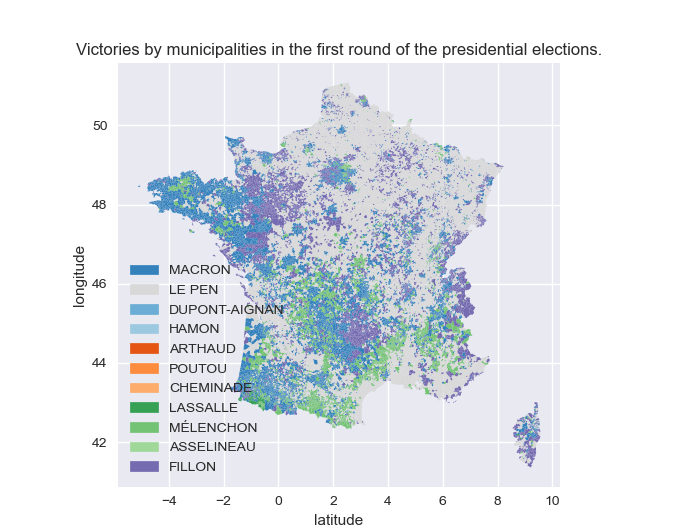

In [8]:
display.Image("images/m1_screen.png")

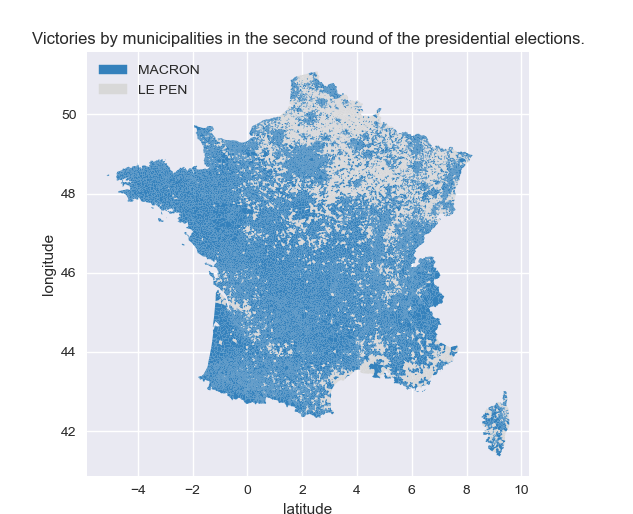

In [9]:
display.Image("images/m2_screen.png")

Spatial data on the geographical position of the municipalities are not directly provided during this challenge in order to avoid cheating. We preferred to provide them in the form of a weighted graph. This graph takes the municipalities as nodes and the distance between municipalities forms a link. If this distance exceeds 10 km there is no link, if it is less than 10 km then we give a value ranging from 0 to 1. 1 being the closest and 0 the farthest. On the graph below we can see the distribution of nodes. We see that the municipalities have an average of around 50 neighbours. But some will have much more, and others much less.


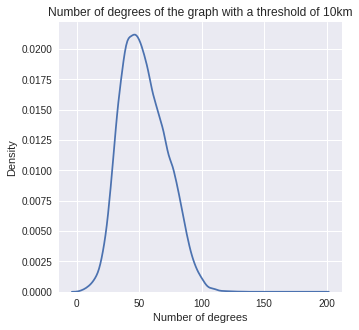

In [17]:
G=nx.read_weighted_edgelist("data/edgelist_dist10000_id")

plt.style.use('seaborn')
g=sns.displot(G.degree,kind="kde")
plt.xlabel("Number of degrees")
plt.ylabel("Density")
plt.title('Number of degrees of the graph with a threshold of 10km')
g._legend.remove()
plt.subplots_adjust(bottom=0.15,top=0.9)

We present below the full graph of France (metropolitan) municipalities. Some regions are more dense than others, and we believe that the spatial distance between municipalities is a predictor of votes results. 

A closer look is given in the following figure, representing Ile de France region, its municipalities and their interconnections.

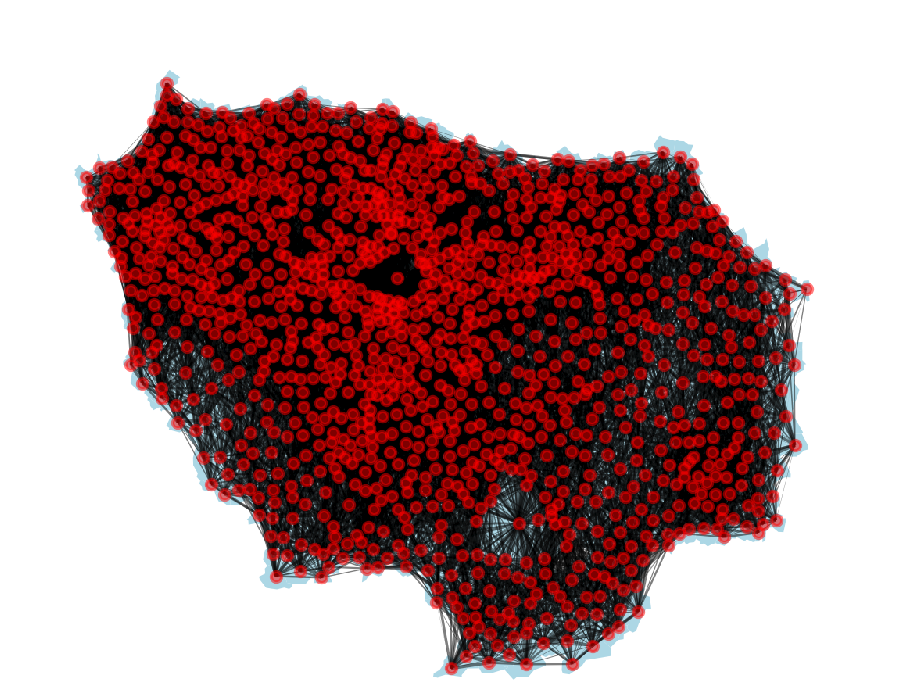

In [10]:
display.Image("images/idf_centroids_screen.png")

## Modelization

We approach the problem of predicting predsidential elections results as a **regression** problem. The goal is to predict the percentage of voices of candidate Emmanuel Macron during the second tour of the election. More precisely, you are given:

- 17589 municipalities for which the results of second tour is known. We call them train nodes to relate to standard Graph litterature.
- 17580 municipalities for which the result of second tour is unknown. We call them test nodes.

Note that the municipalities were splitted in a way that makes sense geographically: for each region, we randomly removed $50\%$ of the municipilaties. We provide below the CV splitter that is used to make such splits.

We believe that approaching election results as a regression problem makes more sense when votes are conducted using the universal suffrage. Indeed, if we have a good estimate of the results and a good estimate of the number of voters for each missing municipalities, then we can easily calculate the election outcome. Approaching this problem as a classification task does not help in a setting where we want to know the global results since there is a notion of averaging over the number of voters.

The metric used for this challenge will be the **Mean Absolute Error (MAE)**, which indicates the error in percentage point of our model when compared to the true percentage.

### Inputs and outputs

You are given a weighted edgelist that serves as the basis to create the french municipalities graph.

In [2]:
G=nx.read_weighted_edgelist("data/edgelist_dist10000_norm")
list(G.nodes)[:10]

['0', '327', '329', '332', '1254', '1870', '3463', '3470', '3977', '3980']

Each node in the graph is a `node_id` that will serve as a merge key with the `node_features.csv` file.

In [3]:
node_features = pd.read_csv('data/node_features.csv', low_memory = False)
node_features['node_id'] = node_features['node_id'].astype(str)
#We need to put node_id as string as the Graph and test/train nodes are in string

In [4]:
node_features.head(2)

,node_id,reg_id,dep_id,Inscrits_t2,Votants_t1,Abstentions_t1,Inscrits_t1,Resultat_t1,Population,Evolution Population,Nb Majeurs,Nb Etudiants,Nb propriétaire,Nb Logement Secondaire et Occasionnel,Nb Occupants Résidence Principale,Score Urbanité,Indice Evasion Client,Capacité Fiscale
0,0,0,0,887,723.0,164.0,887.0,"{'Marine LE PEN': 184, 'Emmanuel MACRON': 155,...",816.0,-15.0,639.0,58.0,284.0,127.0,814.0,0.0,0.0,118.0
1,1,0,0,4358,3296.0,1061.0,4357.0,"{'Marine LE PEN': 788, 'Emmanuel MACRON': 741,...",6456.0,624.0,4643.0,526.0,1045.0,49.0,6323.0,87.5,0.0,190.0


- `reg_id` is the region id that can be used to merge with the `region_df.csv`.
- `dep_id` is the department id.
- `y` is the outcome. It is a number between 0 and 1 indicating the percentage of voters that voted for candidate Macron. 
- `Resultat_t1` is a dictionary that stores results of first tour.

We can easily create features that indicate the results of first tour using the `Resultat_t1` feature:

In [5]:
node_features['Y_t1_macron'] = node_features['Resultat_t1'].apply(lambda x: eval(x)['Emmanuel MACRON'])
node_features['Y_t1_lepen'] = node_features['Resultat_t1'].apply(lambda x: eval(x)['Marine LE PEN'])
voters = node_features['Y_t1_macron'] + node_features['Y_t1_lepen']

node_features['Y_t1_macron'] /= voters
node_features['Y_t1_lepen'] /= voters

node_features[['Y_t1_macron','Y_t1_lepen']] = node_features[['Y_t1_macron','Y_t1_lepen']].fillna(0)


In [6]:
node_features[['Y_t1_macron','Y_t1_lepen']].head(2)

,Y_t1_macron,Y_t1_lepen
0,0.457227,0.542773
1,0.484630,0.515370



Here we created two features: given the voters that voted either for Macron or Le Pen, we calculate the percentage of voters that voted for the two candidates.

In [7]:
#We add the region data as additional features
region_df = pd.read_csv('data/region.csv')
node_features = node_features.merge(region_df, on = 'reg_id')


Below, we introduce the CV splitter that allows to make cross validation by splitting data between each region.

In [8]:
from sklearn.model_selection import BaseCrossValidator

class RegionalSplit(BaseCrossValidator):

    def __init__(self, n_splits = 10, reg_col='reg_id', test_size = 0.3, random_state=None):  
        self.reg_col = reg_col
        self.test_size = test_size
        self.n_splits = n_splits
        if random_state : 
            self.gen = np.random.default_rng(random_state)
        else : 
            self.gen = np.random.default_rng(np.random.randint(1e10))

    def get_n_splits(self, X, y=None, groups=None):
        return self.n_splits

    def split(self, X, y = None, groups=None):

        n_splits = self.get_n_splits(X, y, groups)
        for i in range(n_splits):
            assert isinstance(X, pd.DataFrame), "Provided data must be a dataframe"
            assert self.reg_col in X.columns
            indices = X.groupby(self.reg_col).indices
            train_nodes = []
            test_nodes = []
            for k,v in indices.items() : 
                test_size_abs = int(len(v) * self.test_size) 
                random_choice = self.gen.choice(len(v), len(v), replace=False)
                test_indices = v[random_choice[:test_size_abs]]
                train_indices =  v[random_choice[test_size_abs:]]
                
                train_nodes.extend(train_indices.tolist())
                test_nodes.extend(test_indices.tolist())
            yield (
                np.array(train_nodes), np.array(test_nodes)
            )

We can load the train and test nodes like this

In [9]:
train_nodes = []
test_nodes = []
with open('data/train_nodes.txt','r') as f :
    for line in f.readlines(): 
        train_nodes.append(line.split('\n')[0])
with open('data/test_nodes.txt','r') as f :
    for line in f.readlines(): 
        test_nodes.append(line.split('\n')[0])

In [10]:
train_nodes[:2], test_nodes[:2]

(['32367', '29621'], ['15726', '24463'])

In [11]:
# We can create a cross validation objects like this. 
# reg_col should be the region id columns
cv = RegionalSplit(n_splits = 10, test_size = 0.5, reg_col = 'reg_id', random_state=2022)
#We get splits based on the train nodes
splits = cv.split(node_features[node_features['node_id'].isin(train_nodes)].reset_index())
#We can also get the train and test indices given by the splits
cvs = [(train,test) for train, test in splits]

### Linear Regression

We can first use a simple linear regression. 

In [12]:
y = pd.read_csv('data/y.csv', index_col = 0)
y.head()

,node_id,y
0,0,0.587849
1,1,0.647779
2,2,0.589744
3,20,0.540260
4,76,0.514286


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

features = [i for i in node_features.columns if i not in  ['y', "Resultat_t1"]]

y = y.iloc[:,1]
X = node_features[features]

train_indices = X[X['node_id'].isin(train_nodes)].index.values
test_indices = X[X['node_id'].isin(test_nodes)].index.values

X_train, y_train = X.loc[train_indices], y.loc[train_indices]
X_test, y_test = X.loc[test_indices], y.loc[test_indices]


model = LinearRegression()
scores= cross_val_score(model, X_train.values, y_train.values, cv = cvs, scoring = "neg_mean_absolute_error")
print(f'Mean CV Score : {scores.mean():0.3f}')

model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(f'MAE TEST: {mean_absolute_error(y_test, preds):0.3f}')

Mean CV Score : -0.037
MAE TEST: 0.037


We obtain a score of $0.037$ which means an average of $3.7$ percentage point of error, which is not that bad !

We provide the code for submitting this result in the `submissions/starting-kit/` folder. More specifically, the kit needs a `FeatureExtractor` python class that first processes the features.

Since node features are fixed for each municipilaties (whether they are in the train or test set), every submission should have access directly to this data. More specifically, the data processed by `problem.py` file will return `X`, a dataframe with only the `node_id` and `reg_id` columns, and the vote results `y`, for the correspond split.

The FeatureExtractor will process the data during initialization. During transform time, the `X` dataframe has the correspond `node_id` and `index`. Processing the data is thus just taking the data at the right index.

In our case, the feature extractor and regressor look like this: 

In [19]:
from sklearn.base import BaseEstimator

# FeatureExtractor uses the predefined node_features, and use them to get the right data based on the index
# of X, when calling transform.

class FeatureExtractor(object) : 
    def __init__(self)  :
        region_df = pd.read_csv('data/region.csv')
        node_features = pd.read_csv('data/node_features.csv', low_memory = False)
        
        node_features['node_id'] = node_features['node_id'].astype(str)
        node_features = node_features.merge(region_df, on = 'reg_id')
        node_features['Y_t1_macron'] = node_features['Resultat_t1'].apply(lambda x: eval(x)['Emmanuel MACRON'])
        node_features['Y_t1_lepen'] = node_features['Resultat_t1'].apply(lambda x: eval(x)['Marine LE PEN'])
        voters = node_features['Y_t1_macron'] + node_features['Y_t1_lepen']

        node_features['Y_t1_macron'] /= voters
        node_features['Y_t1_lepen'] /= voters

        node_features[['Y_t1_macron','Y_t1_lepen']] = node_features[['Y_t1_macron','Y_t1_lepen']].fillna(0)
        node_features.drop(['Resultat_t1'], axis = 1, inplace=True)
        self.node_features = node_features
    
    def fit(self, X_df, y) : 

        pass

    def transform(self, X) :
        # Little turn around to make sure that X and y are well aligned
        X = self.node_features.loc[X.index]
        
        return X.drop(['node_id'],axis=1)
    
class Regressor(BaseEstimator):
    def __init__(self):
        self.model = LinearRegression()

    def fit(self, X, Y):

        self.model.fit(X, Y)

    def predict(self, X):

        res = self.model.predict(X)
        return res

We can test our submission (located in `submissions/starting_kit/`) by running: 

```ramp-test --submission starting_kit```

In [20]:
!ramp-test --submission starting_kit

Testing Forecasting secound round of national elections based on Graphs
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score     MAE      time
	train  0.0367  1.562750
	valid  0.0371  0.015229
	test   0.0370  0.005571
CV fold 1
	score     MAE      time
	train  0.0363  1.574606
	valid  0.0372  0.013461
	test   0.0367  0.010679
CV fold 2
	score     MAE      time
	train  0.0371  1.636887
	valid  0.0365  0.012534
	test   0.0367  0.011029
CV fold 3
	score     MAE      time
	train  0.0367  1.605258
	valid  0.0371  0.006599
	test   0.0369  0.005898
CV fold 4
	score     MAE      time
	train  0.0370  1.616675
	valid  0.0370  0.012842
	test   0.0372  0.012267
CV fold 5
	score     MAE      time
	train  0.0364  1.619915
	valid  0.0373  0.007046
	test   0.0369  0.005151
CV fold 6
	score     MAE      time
	train  0.0364  1.586130
	valid  0.0369  0.011867
	test   0.0365  0.005336
CV fold 7
	score     MAE      time
	train  0.0369  1.579334

### Going further with Graph Neural Networks

Graph neural networks (GNN) are powerful deep learning models that are able to use spatial information into account and process graph-based data. Generally, they consist of *message passing* layers which process the node features of a specific node and its neighbors, creating a latent feature space for each nodes processed. The more *message passing* layers a model has, further *k-hop* neighbors are being processed. 

We believe that efficiently specifying a GNN for processing our data could really improve the predictions.

Useful libraries to work with graph are `networkx` for general purprose and `pytorch-geometric`, a powerful library based on `pytorch` that extend it to graph models.

In [15]:
from torch_geometric.data import Data,Dataset
from torch.utils.data import Subset
from torch_geometric.utils import from_networkx
import torch 
from torch_geometric.loader import DataLoader
from tqdm import tqdm

The `message passing` layers efficiently process features of neighboring municipalities. We can use the fact that the overall graph structure is known, therfore leveraging features of neighbors even if they appear in the test set

In [16]:
from torch_geometric.data import Data
from torch.utils.data import Subset
from torch_geometric.utils import from_networkx
import torch 
from tqdm import tqdm
import networkx as nx 
import pandas as pd
import numpy as np

class FeatureExtractor(object) : 
    def __init__(self)  :

        region_df = pd.read_csv('data/region.csv')
        node_features = pd.read_csv('data/node_features.csv', low_memory = False)
        node_features['node_id'] = node_features['node_id'].astype(str)
        node_features = node_features.merge(region_df, on = 'reg_id')
        node_features['Y_t1_macron'] = node_features['Resultat_t1'].apply(lambda x: eval(x)['Emmanuel MACRON'])
        node_features['Y_t1_lepen'] = node_features['Resultat_t1'].apply(lambda x: eval(x)['Marine LE PEN'])
        voters = node_features['Y_t1_macron'] + node_features['Y_t1_lepen']

        node_features['Y_t1_macron'] /= voters
        node_features['Y_t1_lepen'] /= voters
    
        node_features[['Y_t1_macron','Y_t1_lepen']] = node_features[['Y_t1_macron','Y_t1_lepen']].fillna(0)
        
        #Scaling features as they are the input of a Neural Network
        to_scale = [i for i in node_features.columns if i not in  ['reg_id','dep_id',"Resultat_t1", 
                                                                   "node_id"]]
        scale = (node_features[to_scale].max() - node_features[to_scale].min())
        node_features[to_scale] = (node_features[to_scale] -node_features[to_scale].mean()) / scale

        self.node_features = node_features
        
        # region ids and department ids will be processed by an embedding since
        # they are categorical features
        reg_ids = dict(zip(node_features['node_id'], node_features['reg_id']))
        dep_ids = dict(zip(node_features['node_id'], node_features['dep_id']))

        self.G = nx.read_weighted_edgelist('data/edgelist_dist10000_norm')
        node_features_ = dict(zip(node_features['node_id'], node_features[to_scale].values))

        nx.set_node_attributes(self.G, node_features_, 'x')
        nx.set_node_attributes(self.G, reg_ids, 'reg_id')
        nx.set_node_attributes(self.G, dep_ids, 'dep_id')
        
        # IMPORTANT: this mapper maps node_id in the graph G to their position in the 
        # G.nodes method. By default, creating a Data object from networkx will use the ordering
        # of G.nodes method, hence we need to define this mapper to have acces to the good indices.
        self.mapper = dict(zip([int(i) for i in list(self.G.nodes)], list(range(self.G.number_of_nodes()))))

    def fit(self, X_df, y) : 
        # The fit method only stores the y values to make it available
        # during transform timle
        self.y = torch.from_numpy(y)

        pass
    
    def transform(self, X) :
        # We create a Data object from PyTorch Geometric. It contains all the required data
        # to be processed by a GNN.
        
        ids = X['node_id'].astype(int).values
        # IMPORTANT: when creating a Data object with the from_networkx method,
        # the order of the nodes is the same as returned by the G.nodes method
        # In our case, the node ids are not ordered and we need to use a mapper
        # to move from node_id to position in the Data object. 
        data = from_networkx(self.G)
        
        # The mask represent the indices that will be used during training. More specifically
        # our GNN returns a N dimension output (where N = total number of municipalities)
        # but we only have access to the mask indices y values.
        data.mask = torch.LongTensor([self.mapper[i] for i in [int(i) for i in ids]])
        
        data.edge_index = data.edge_index.long()
        data.x = data.x.float()
        data.y = self.y
        
        #Returning a list is a little turnaround to make it work with ramp-test command.
        return [data] 

We can now define our model class using pytorch and pytorch geometric

In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.base import BaseEstimator

class GCN(torch.nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.feat_map1 = torch.nn.Linear(input_features, 32)

        self.reg_emb = torch.nn.Embedding(22, 16)
        self.dep_emb = torch.nn.Embedding(96, 16)

        self.conv1 = SAGEConv(32 + 16*2 , 16, normalize = False)
        self.conv2 = SAGEConv(16, 32, normalize = False)
        self.lin = torch.nn.Linear(32, 1)


    def forward(self, data, train = True):
        x, edge_index = data.x, data.edge_index
        reg_ids = data.reg_id
        dep_ids = data.dep_id
        
        reg_fm = self.reg_emb(reg_ids)
        dep_fm = self.dep_emb(dep_ids)
        
        # First project input data by a linear feature map
        x = self.feat_map1(x)
        
        # Concatenation with departement and region embeddings to 
        # create our GNN input
        x = torch.cat([x, reg_fm, dep_fm],1)
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.lin(x)
        
        return x
    
    
class Regressor(BaseEstimator):
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def fit(self, data, Y):
        data = data[0]
        self.model = GCN(data.num_node_features).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.005, weight_decay = 5e-3)
        self.criterion = torch.nn.L1Loss()
        
        data = data.to(self.device)
        self.model.train()
        pbar = tqdm(range(500))
        for epoch in pbar:
            total_loss = 0 

            self.optimizer.zero_grad()
            out = self.model(data)
            loss = self.criterion(out[data.mask], data.y.float())
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            pbar.set_description(f'Epoch {epoch+1}, Loss : {(total_loss):0.4f}')
        
    def predict(self, data):
        with torch.no_grad() : 
            data = data[0].to(self.device)
            self.model.eval()
            out = self.model(data)
            out = (out[data.mask])
            
            return out.detach().cpu().numpy()

In [32]:
extractor = FeatureExtractor()
extractor.fit(X_train, y_train.values.reshape(-1,1))
data_train = extractor.transform(X_train)
data_test = extractor.transform(X_test)

In [30]:
data_train[0]

Data(x=[35169, 23], edge_index=[2, 1892598], reg_id=[35169], dep_id=[35169], weight=[1892598], mask=[17589], y=[1599, 11])

In [33]:
model = Regressor()
model.fit(data_train, data_train[0].y)

Epoch 500, Loss : 0.0345: 100%|███████████████| 500/500 [00:20<00:00, 24.20it/s]


In [38]:
preds = model.predict(data_test)
print(f'GNN TEST MAPE : {mean_absolute_error(y_test.values, preds):0.3f}')

GNN TEST MAPE : 0.034


We can test our submission (located in `submissions/gnn/`) by running the same command as above

In [24]:
!ramp-test --submission gnn

Testing Forecasting secound round of national elections based on Graphs
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/gnn ...
CV fold 0
Epoch 500, Loss : 0.0337: 100%|███████████████| 500/500 [00:20<00:00, 24.55it/s]
	score     MAE       time
	train  0.0337  36.825554
	valid  0.0344   8.939989
	test   0.0340   9.286047
CV fold 1
Epoch 500, Loss : 0.0332: 100%|███████████████| 500/500 [00:19<00:00, 25.30it/s]
	score     MAE       time
	train  0.0332  33.387498
	valid  0.0348   9.027479
	test   0.0339   8.572506
CV fold 2
Epoch 500, Loss : 0.0339: 100%|███████████████| 500/500 [00:19<00:00, 25.33it/s]
	score     MAE       time
	train  0.0340  32.520724
	valid  0.0340   9.192578
	test   0.0339   9.070975
CV fold 3
Epoch 500, Loss : 0.0338: 100%|███████████████| 500/500 [00:19<00:00, 25.31it/s]
	score     MAE       time
	train  0.0338  33.117218
	valid  0.0344   9.287624
	test   0.0339   9.179309
CV fold 4
Epoch 500, Loss : 0.0339: 100%|███████████████| 

We see a small improvement by using a basic Graph Neural Network. We believe that there is a lot of interesting ideas to test using the graph litterature. 

One of the key improvement should rely in using the election results, `y` as a feature to be processed by the GNN. Indeed, at testing time, the result of all training municipalities is already known and should be used as a regressor for predicting the test municipalities results. While this idea of using `y` as a regressor makes no sense in usual regression setups, it can make sense in a graph regression setup. 

Another lead for improvement could be by using the edge weights. Our graph is weighted, which means that their distant neighbors have a lower weight than its direct neighbors (in the graph). The edge weights can be easily incorporated in many GNN architectures. You can find more information in the [PyTorch Geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html).

Your solution should at least be better than the GNN solution. 

## Quick submission test

Make sure the local processing runs by using the ramp-test command.
```
ramp-test --submission <submission folder>
```
If you want to quickly test the that there are no obvious code errors, use the `--quick-test` flag to only use a small subset of the data (training and testing sets with 5 elements each).

```
ramp-test --submission <submission folder> --quick-test
```

See the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html) for more details.